### Load and Prepare Data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Load in data: df
df = pd.read_csv('https://s3.amazonaws.com/clcarverloans/data/df_cleaned.csv')

In [3]:
# Remove usesless rows: df_select
cols = ['Borrower_Genders', 'Country Code', 'Loan Amount', 'Lender_Term',
       'Repayment_Interval', 'Distribution_Model', 'Sector', 'Activity','Delinquent']
df_select = df[cols]

# One_hot_encode categorical columns: df_dummies
df_dummies = pd.get_dummies(df_select)

# Select features and target: X, y
y = df_dummies.pop('Delinquent')
X = df_dummies

In [4]:
# Split data into train and test set: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

____

# Create Trade-off Metric

### Calculate Averages

First off, we should know what the average principal per loan is

In [5]:
average_loan_amount = df['Loan Amount'].mean()
print('Average Loan Size is: $', average_loan_amount)

Average Loan Size is: $ 770.9566877046869


Next, we should know average interest rate of the loan. According to Kiva's Q&A section the field partners charge around 36%

In [6]:
average_interest_rate = 0.36
print('Average Interest Rate: {}%'.format(int(average_interest_rate*100)))

Average Interest Rate: 36%


In [7]:
average_profit = average_loan_amount * average_interest_rate
print('Average Profit Per Loan: $', average_profit)

Average Profit Per Loan: $ 277.5444075736873


In [14]:
cost_benefit_matrix = np.array([[0, -average_profit], [-average_loan_amount, 0]])

This means, on average, the banks make around $278 dollars per loan. The resulting cost benefit matrix would look like so:

TP = 0, FP = -278, FN = -770, TN = +278

### Create Functions to Create Profit Curve

In [33]:
# Create a function that returns an array of the profits at each threshold: profit_curve
def profit_curve(cost_benefit, predicted_probs, labels):
    
    labels = labels.values
    
    # Sort the probabilities: sorted_probs
    sorted_probs = np.sort(predicted_probs)
    
    # Sort the labels: sorted_labels
    sorted_labels =  labels[np.argsort(sorted_probs)]#labels.reset_index().iloc[np.argsort(predicted_probs)]['Delinquent']
    
    # Make predictions at each threshold level: y_predictions
    y_predictions = [] # List of a list of predictions
    #y_predictions.append((0, np.zeros(sorted_labels.shape)))
    
    for proba in np.unique(np.round(sorted_probs,3)):
        temp = np.zeros(labels.shape)
        temp[predicted_probs >= proba] = 1 # Append the predictions at each threshold
        y_predictions.append((proba, temp)) 
            #y_predictions.append((sorted_probs[i], (sorted_probs >= sorted_probs[i]))) # Append the predictions at each threshold
           
    # Calculate profit for each confusion matrix: profit_list
    profit_list = []
    for prob, y_pred in y_predictions: # For the predictions at each threshold
        conf_matrix = confusion_matrix(sorted_labels, y_pred) # Create a confusion matrix
        conf_matrix_norm = conf_matrix/(np.sum(conf_matrix)) # Divide it by the total number of data points
        value_matrix = np.multiply(conf_matrix_norm, cost_benefit) # Multiply it by the cost_benefit matrix
        profit = np.sum(value_matrix) # Sum it for the total profit
       #import pdb; pdb.set_trace()
        profit_list.append(profit)  # Profit at single threshold added to profit_list  
    
    # Return an array of the profits at each threshold
    return profit_list

In [34]:
# Build a function that plots our profit curve: plot_profit_curve
def plot_profit_curve(model, cost_benefit, X_train, X_test, y_train, y_test):
    #model.fit(X_train, y_train) # Fit the model
    probs = model.predict_proba(X_test)[:,1] # Compute probabilities for each data point
    profits = profit_curve(cost_benefit, probs, y_test) # Find profits at each probability threshold
    percentages = np.arange(0, 100, 100. / len(profits))
    ax = plt.plot(percentages, profits) # Plot profits
    plt.title("Profit Curve")
    plt.ylabel("Profit")
    plt.show()

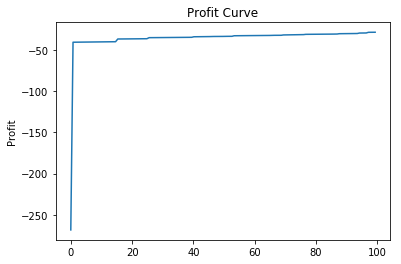

In [35]:
plot_profit_curve(rf, cost_benefit_matrix, X_train, X_test, y_train, y_test)

[[   0.           -0.        ]
 [-385.47834385    0.        ]]
[[   0.         -138.77220379]
 [  -0.            0.        ]]
[[  0.         -69.38610189]
 [ -0.           0.        ]]
[[   0.          -69.38610189]
 [-192.73917193    0.        ]]
[[   0.           -0.        ]
 [-192.73917193    0.        ]]


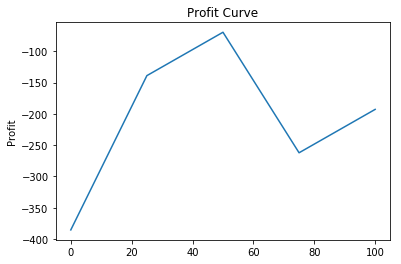

[  0.  25.  50.  75. 100.] [-385.47834385234347, -138.77220378684365, -69.38610189342182, -262.12527381959353, -192.73917192617174]


In [105]:
blah = np.sort(probs)

b2 = y_testing[np.argsort(probs)]

# Make predictions at each threshold level: y_predictions
y_predictions = [] # List of a list of predictions
y_predictions.append(np.zeros(blah.shape))

for prob in blah:
    temp = np.zeros(blah.shape)
    temp[blah >= prob] = 1 # Append the predictions at each threshold
    y_predictions.append(temp) 
    
# Calculate profit for each confusion matrix: profit_list
profit_list = []
for y_pred in y_predictions: # For the predictions at each threshold
    conf_matrix = confusion_matrix(b2, y_pred) # Create a confusion matrix
    conf_matrix_norm = conf_matrix/(np.sum(conf_matrix)) # Divide it by the total number of data points
    value_matrix = np.multiply(conf_matrix_norm, cost_benefit_matrix) # Multiply it by the cost_benefit matrix
    print(value_matrix)
    profit = np.sum(value_matrix) # Sum it for the total profit
    profit_list.append(profit)  # Profit at single threshold added to profit_list 

percentages = np.linspace(0, 100, num= len(profit_list))
ax = plt.plot(percentages, profit_list) # Plot profits
plt.title("Profit Curve")
plt.ylabel("Profit")
plt.show()

print(percentages, profit_list)


In [63]:
# Build a function that plots our profit curve: plot_profit_curve
def plot_profit_curve(model, cost_benefit, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) # Fit the model
    probs = model.predict_proba(X_test)[:,1] # Compute probabilities for each data point
    profits = profit_curve(cost_benefit, probs, y_test) # Find profits at each probability threshold
    percentages = np.arange(0, 100, 100. / len(profits))
    ax = plt.plot(percentages, profits) # Plot profits
    plt.title("Profit Curve")
    plt.ylabel("Profit")
    plt.show()

In [60]:
average_loan_amount

770.9566877046869

In [57]:
cost_benefit_matrix = np.array([[0, -average_profit], [-average_loan_amount, 0]])

In [69]:
print(cost_benefit_matrix)

[[   0.         -277.54440757]
 [-770.9566877     0.        ]]


In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
.0331 * -770

-25.487

In [27]:
rfprobs = rf.predict_proba(X_test)[:,1]

preds = np.zeros(rfprobs.shape)

preds[rfprobs > .7] = 1


In [29]:
len(np.unique(np.round(rfprobs,3)))

137

In [102]:
c1 = confusion_matrix(y_test, preds) / len(y_test)
print(c1)

np.multiply(c1, cost_benefit_matrix)

[[0.96437673 0.00249417]
 [0.01377216 0.01935694]]


array([[  0.        ,  -0.69224328],
       [-10.61774108,   0.        ]])

In [68]:
y_test.sum() * -771

-471081

___

In [15]:
from sklearn.metrics import roc_curve

# Create a function that returns an array of the number of borrowers blocked at each threshold: trade_off_curve
def trade_off_curve(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    tpr, fpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('% of Good Borrowers Blocked')
    plt.ylabel('% of Defaulters Blocked')

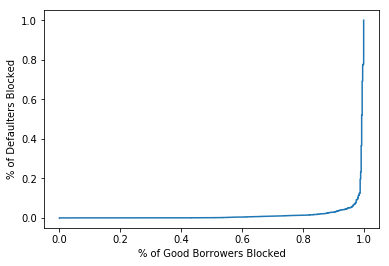

In [16]:
trade_off_curve(logreg, X_train, X_test, y_train, y_test)